In [ ]:
from Bio import SeqIO
from Bio import Entrez
from Bio.SeqFeature import SeqFeature, FeatureLocation
import re
import pandas as pd
import gzip
import re

import matplotlib.pyplot as plt

In [209]:
def create_metadata(name, startId, lastId):
    lastId = lastId + 1
    access_id = []
    isolate = []
    isolation_source = []
    country = []

    Entrez.email = "syuzi.matevosyan1802@gmail.com"
    for id in range(startId, lastId):
        filename = name + str(id)
        net_handle = Entrez.efetch(
            db="nucleotide", id=filename, rettype="gb", retmode="text"
        )
        record = SeqIO.read(net_handle, "gb")
        access_id.append(filename)
        isolate.append(record.features[0].qualifiers.get("isolate", ["None"])[0])
        isolation_source.append(record.features[0].qualifiers.get("isolation_source", ["None"])[0])
        country.append(record.features[0].qualifiers.get("country", ["None"])[0])
        print(id)
    metadata = pd.DataFrame({"access_id": access_id, "isolate": isolate, "isolation_source": isolation_source, "country": country})
    return metadata



In [ ]:
df1 = create_metadata("MK491", 355, 495)
df2 = create_metadata("HM852", 756, 902)
df3 = create_metadata("KC911", 275, 629)
df4 = create_metadata("MF362", 744, 949)



In [242]:
frames = [df1, df2, df3, df4]
result = pd.concat(frames)
result.to_csv("../metadata.csv")

In [243]:
meta = pd.read_csv("../metadata.csv")
meta

,Unnamed: 0,access_id,isolate,isolation_source,country
0,0,MK491355,1_Mu,Armenian individual,Turkey: Mush
1,1,MK491356,2_Mu,Armenian individual,Turkey: Mush
2,2,MK491357,3_Mu,Armenian individual,Turkey: Mush
3,3,MK491358,4_Mu,Armenian individual,Turkey: Mush
4,4,MK491359,5_Mu,Armenian individual,Turkey: Mush
...,...,...,...,...,...
844,201,MF362945,Erzrum_81,Armenian Erzrum_81,Turkey: Erzrum
845,202,MF362946,Erzrum_82,Armenian Erzrum_82,Turkey: Erzrum
846,203,MF362947,Erzrum_84,Armenian Erzrum_84,Turkey: Erzrum
847,204,MF362948,Erzrum_85,Armenian Erzrum_85,Turkey: Erzrum


In [244]:
meta.iloc[288]

Unnamed: 0                 0
access_id           KC911275
isolate                  NaN
isolation_source     Qashqai
country                 Iran
Name: 288, dtype: object

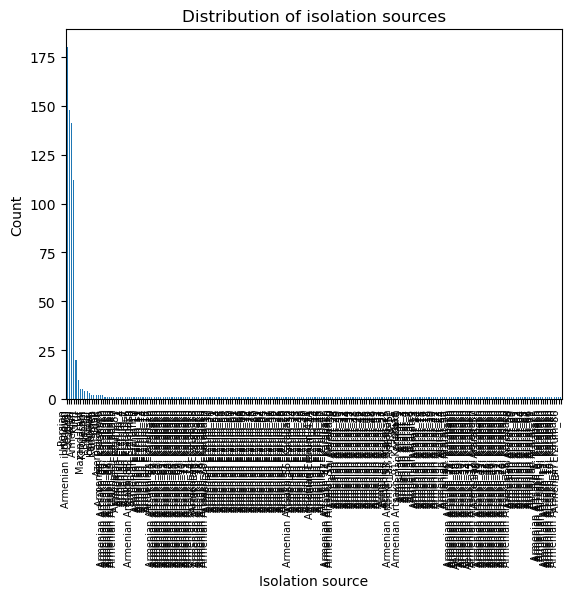

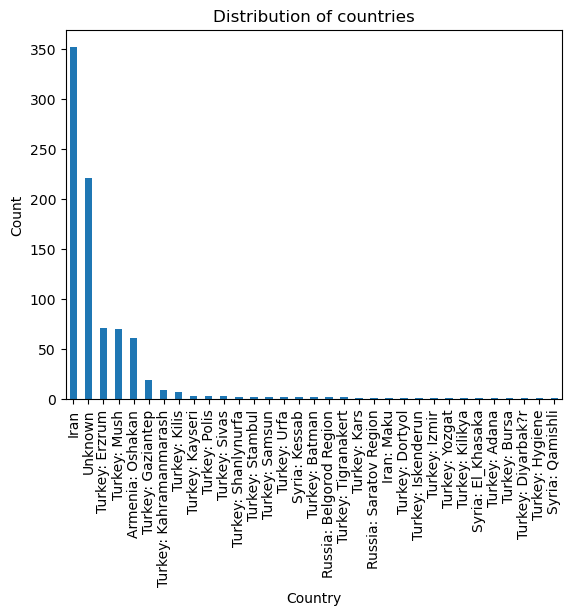

In [245]:

meta.fillna("Unknown", inplace=True)
# Plot the distribution of isolation sources
meta["isolation_source"].value_counts().plot(kind="bar")
plt.title("Distribution of isolation sources")
plt.xlabel("Isolation source")
plt.ylabel("Count")
plt.xticks(fontsize=7, ha="right")
plt.show()

# Plot the distribution of countries
meta["country"].value_counts().plot(kind="bar")
plt.title("Distribution of countries")
plt.xlabel("Country")
plt.ylabel("Count")
plt.show()



In [247]:
# Function to extract VCF column names from a gzipped VCF file
def get_vcf_names(vcf_path):
    with gzip.open(vcf_path, "rt") as ifile:
        for line in ifile:
            if line.startswith("#CHROM"):
                vcf_names = [x for x in line.split('\t')]
                break
    ifile.close()
    return vcf_names

# Function to create a DataFrame from a gzipped VCF file

def create_vcf(vcf_path):
    vcf = pd.read_csv(vcf_path, compression='gzip', comment='#', delim_whitespace=True, header=None, names=names)
    return vcf

In [257]:
# Generate patient IDs and VCF file paths
patients = []
path_name = []

for i in range(355, 496):
    patients.append('MK491' + str(i)) 
    path_name.append('../../samples/arm_samples/anno/MK491' + str(i) + '.vcf.anno.vcf.gz')


for i in range(756, 902):
    patients.append('HM852' + str(i)) 
    path_name.append('../../samples/other_samples/HM852' + str(i) + '.vcf.anno.vcf.gz')


for i in range(275, 629):
    patients.append("KC911" + str(i)) 
    path_name.append('../../samples/other_samples/KC911' + str(i) + '.vcf.anno.vcf.gz')


for i in range(744, 949):
    patients.append('MF362' + str(i)) 
    path_name.append('../../samples/other_samples/MF362' + str(i) + '.vcf.anno.vcf.gz')

In [250]:
# Create an empty DataFrame to store matrix data

matrix_data = pd.DataFrame(index=patients, columns=genes, dtype=int)
matrix_data = matrix_data.fillna(0)

In [251]:


# List of target genes
genes = ["ND1", "ND2", "COX1", "COX2", "ATP6", "ATP8", "ND3", "ND4", "ND4L", "ND5", "ND6", "CYTB", "COX3"]

def find_gene_match_one(input_sample):
    input_sample["INFO"] = input_sample["INFO"].str.strip("|")
    split_data = input_sample["INFO"].str.split("|", expand=True)
    num_columns = len(split_data.columns)
    new_column_names = [f"column_{i}" for i in range(num_columns)]
    split_data.columns = new_column_names
    input_sample = pd.concat([input_sample, split_data], axis=1)
    input_sample.drop(columns=["INFO"], inplace=True)
    return input_sample["column_3"]


for (file, patient) in zip(path_name, patients):
    names = get_vcf_names(file)  # Get VCF column names
    vcf = create_vcf(file)       # Create DataFrame from VCF file
    gene_column = find_gene_match_one(vcf)
    j = j + 1
    for gene in genes:
        if (gene_column.str.contains(gene).any()):
            matrix_data.loc[patient].at[gene] = 1
        else:
            matrix_data.loc[patient].at[gene] = 0

matrix_data

,ND1,ND2,COX1,COX2,ATP6,ATP8,ND3,ND4,ND4L,ND5,ND6,CYTB,COX3
MK491355,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
MK491356,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
MK491357,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
MK491358,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
MK491359,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
MF362944,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
MF362945,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
MF362946,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
MF362947,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0


In [252]:
matrix_data.to_csv("../matrix.csv")

In [254]:
matrix_data = pd.read_csv("../matrix.csv", index_col = "Unnamed: 0")
matrix_data

,ND1,ND2,COX1,COX2,ATP6,ATP8,ND3,ND4,ND4L,ND5,ND6,CYTB,COX3
MK491355,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
MK491356,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
MK491357,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
MK491358,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
MK491359,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
MF362944,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
MF362945,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
MF362946,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
MF362947,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0


In [255]:
import seaborn as sns
import matplotlib.pyplot as plt 


<Axes: >

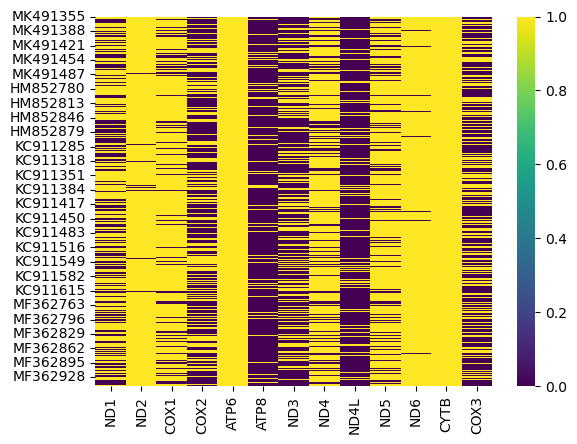

In [256]:
sns.heatmap(matrix_data, cmap="viridis")

In [333]:

def get_gene_column(input_sample):
    input_sample["INFO"] = input_sample["INFO"].str.strip("|")
    split_data = input_sample["INFO"].str.split("|", expand=True)
    num_columns = len(split_data.columns)
    new_column_names = [f"column_{i}" for i in range(num_columns)]
    split_data.columns = new_column_names
    input_sample = pd.concat([input_sample, split_data], axis=1)
    input_sample.drop(columns=["INFO"], inplace=True)
    return input_sample[["column_1", "column_3", "column_7", "column_9", "column_10"]]


gene_variant = []
gene = []
gene_type = []
mutation_aminoacide = []
mutation_nucleotide = []

for (file, patient) in zip(path_name, patients):
    names = get_vcf_names(file)  # Get VCF column names
    vcf = create_vcf(file)       # Create DataFrame from VCF file
    gene_column = get_gene_column(vcf)
    contains_atp = gene_column.apply(lambda x: x.str.find("ATP") == 0)
    filtered_rows = gene_column[contains_atp.any(axis=1)]
    gene_variant.append(filtered_rows.iloc[0][0])
    gene.append(filtered_rows.iloc[0][1])
    gene_type.append(filtered_rows.iloc[0][2])
    mutation_nucleotide.append(filtered_rows.iloc[0][3])
    mutation_aminoacide.append(filtered_rows.iloc[0][4])


dataframe_ATP = pd.DataFrame({ "Patient": patients, "gene_variant": gene_variant, "gene": gene, "gene_type": gene_type, "mutation_nucleotide": mutation_nucleotide, "mutation_aminoacide" : mutation_aminoacide})
  

In [334]:
dataframe_ATP

,Patient,gene_variant,gene,gene_type,mutation_nucleotide,mutation_aminoacide
0,MK491355,missense_variant,ATP6,protein_coding,c.334A>G,p.Thr112Ala
1,MK491356,synonymous_variant,ATP6,protein_coding,c.171G>A,p.Met57Met
2,MK491357,missense_variant,ATP6,protein_coding,c.334A>G,p.Thr112Ala
3,MK491358,synonymous_variant,ATP6,protein_coding,c.88T>C,p.Leu30Leu
4,MK491359,missense_variant,ATP6,protein_coding,c.334A>G,p.Thr112Ala
...,...,...,...,...,...,...
841,MF362944,missense_variant,ATP6,protein_coding,c.334A>G,p.Thr112Ala
842,MF362945,missense_variant,ATP6,protein_coding,c.334A>G,p.Thr112Ala
843,MF362946,missense_variant,ATP6,protein_coding,c.334A>G,p.Thr112Ala
844,MF362947,synonymous_variant,ATP6,protein_coding,c.171G>A,p.Met57Met


In [335]:
def get_gene_column(input_sample):
    input_sample["INFO"] = input_sample["INFO"].str.strip("|")
    split_data = input_sample["INFO"].str.split("|", expand=True)
    num_columns = len(split_data.columns)
    new_column_names = [f"column_{i}" for i in range(num_columns)]
    split_data.columns = new_column_names
    input_sample = pd.concat([input_sample, split_data], axis=1)
    input_sample.drop(columns=["INFO"], inplace=True)
    return input_sample[["column_1", "column_3", "column_7", "column_9", "column_10" ]]


gene_variant = []
gene = []
gene_type = []
mutation_nucleotide = []
mutation_aminoacide = []
for (file, patient) in zip(path_name, patients):
    names = get_vcf_names(file)  # Get VCF column names
    vcf = create_vcf(file)       # Create DataFrame from VCF file
    gene_column = get_gene_column(vcf)
    contains_atp = gene_column.apply(lambda x: x.str.find("CYTB") == 0)
    filtered_rows = gene_column[contains_atp.any(axis=1)]
    gene_variant.append(filtered_rows.iloc[0][0])
    gene.append(filtered_rows.iloc[0][1])
    gene_type.append(filtered_rows.iloc[0][2])
    mutation_nucleotide.append(filtered_rows.iloc[0][3])
    mutation_aminoacide.append(filtered_rows.iloc[0][4])


dataframe_CYTB = pd.DataFrame({ "Patient": patients, "gene_variant": gene_variant, "gene": gene, "gene_type": gene_type, "mutation_nucleotide": mutation_nucleotide, "mutation_aminoacide" : mutation_aminoacide})

In [336]:
dataframe_CYTB

,Patient,gene_variant,gene,gene_type,mutation_nucleotide,mutation_aminoacide
0,MK491355,missense_variant,CYTB,protein_coding,c.20C>T,p.Thr7Ile
1,MK491356,missense_variant,CYTB,protein_coding,c.20C>T,p.Thr7Ile
2,MK491357,missense_variant,CYTB,protein_coding,c.20C>T,p.Thr7Ile
3,MK491358,missense_variant,CYTB,protein_coding,c.20C>T,p.Thr7Ile
4,MK491359,synonymous_variant,CYTB,protein_coding,c.210T>G,p.Thr70Thr
...,...,...,...,...,...,...
841,MF362944,missense_variant,CYTB,protein_coding,c.20C>T,p.Thr7Ile
842,MF362945,missense_variant,CYTB,protein_coding,c.20C>T,p.Thr7Ile
843,MF362946,missense_variant,CYTB,protein_coding,c.20C>T,p.Thr7Ile
844,MF362947,missense_variant,CYTB,protein_coding,c.20C>T,p.Thr7Ile


In [337]:
unique_values = dataframe_ATP['gene_variant'].unique()
print(unique_values)


unique_values = dataframe_CYTB['gene_variant'].unique()
print(unique_values)


['missense_variant' 'synonymous_variant' 'initiator_codon_variant']
['missense_variant' 'synonymous_variant']


In [338]:
filtered_rows = dataframe_ATP[dataframe_ATP['gene_variant'] == "initiator_codon_variant"]
filtered_rows

,Patient,gene_variant,gene,gene_type,mutation_nucleotide,mutation_aminoacide
372,KC911360,initiator_codon_variant,ATP6,protein_coding,c.1A>G,p.Met1?


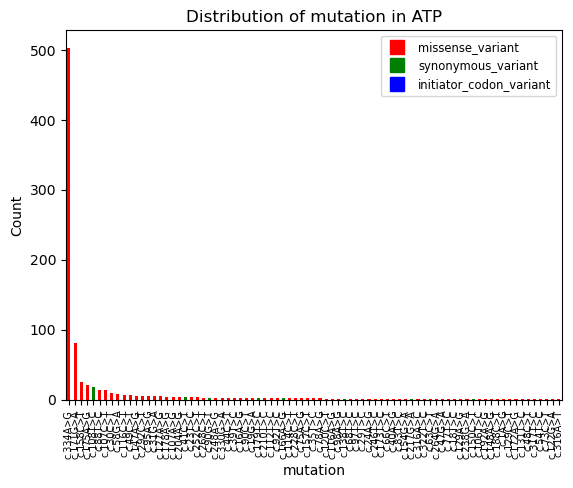

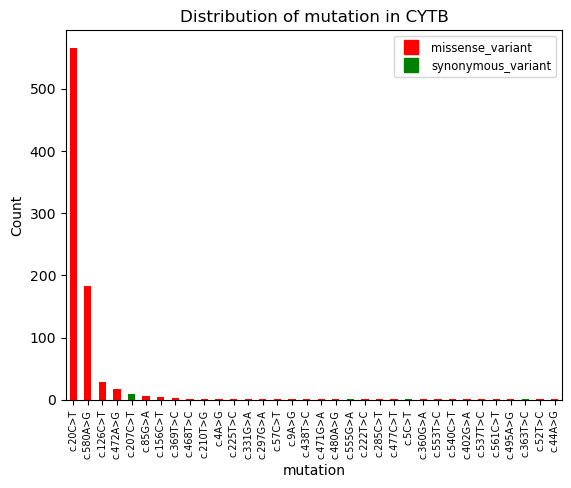

In [320]:
color_map_ATP = {"missense_variant": "red", "synonymous_variant": "green", "initiator_codon_variant": "blue"}
dataframe_ATP["color"] = dataframe_CYTB["gene_variant"].map(color_map_ATP)
dataframe_ATP["mutation"].value_counts().plot(kind="bar", color=dataframe_ATP["color"])
plt.title("Distribution of mutation in ATP")
plt.xlabel("mutation")
plt.ylabel("Count")
plt.xticks(fontsize=7)
patches = [plt.plot([],[], marker="s", ms=10, ls="", mec=None, color=color_map_ATP[key], label=key)[0] for key in color_map_ATP]
plt.legend(handles=patches, loc="best", fontsize="small")
plt.show()


color_map_CYTB = {"missense_variant": "red", "synonymous_variant": "green"}
dataframe_CYTB["color"] = dataframe_CYTB["gene_variant"].map(color_map_CYTB)
dataframe_CYTB["mutation"].value_counts().plot(kind="bar", color=dataframe_CYTB["color"])
plt.title("Distribution of mutation in CYTB")
plt.xlabel("mutation")
plt.ylabel("Count")
plt.xticks(fontsize=7)
patches = [plt.plot([],[], marker="s", ms=10, ls="", mec=None, color=color_map_CYTB[key], label=key)[0] for key in color_map_CYTB]
plt.legend(handles=patches, loc="best", fontsize="small")
plt.show()



Performing clustering 

In [339]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Number of clusters
num_clusters = 3
n_init = 10
# Perform k-means clustering
kmeans = KMeans(n_clusters=num_clusters, n_init = n_init, random_state=0)
#means.fit(matrix_data)
cluster_labels = kmeans.fit_predict(matrix_data)

# Add cluster labels to the data
data_with_clusters = pd.DataFrame(matrix_data)
data_with_clusters['Cluster'] = cluster_labels


data_with_clusters

,ND1,ND2,COX1,COX2,ATP6,ATP8,ND3,ND4,ND4L,ND5,ND6,CYTB,COX3,Cluster
MK491355,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,2
MK491356,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0
MK491357,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0
MK491358,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0
MK491359,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MF362944,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,2
MF362945,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0
MF362946,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2
MF362947,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0


In [ ]:
data_with_clusters_ordered = data_with_clusters.copy()
#data_with_clusters_ordered['population'] = "a"
lst = []
lst = meta['isolation_source']
lst = pd.DataFrame(lst)

data_with_clusters_ordered['isolation_source'] = meta['isolation_source'].copy()

for i in range(0, 846):
    data_with_clusters_ordered['isolation_source'][i] = str(meta['isolation_source'][i])

# Print the resulting DataFrame
data_with_clusters_ordered.to_csv("../clustered.csv")


In [345]:
data_with_clusters_ordered = pd.read_csv("../clustered.csv")
data_with_clusters_ordered.reset_index()
data_with_clusters_ordered.sort_values(by='Cluster', inplace=True)

data_with_clusters_ordered.to_csv("../clustered_ordered.csv")
data_with_clusters_ordered

,Unnamed: 0,ND1,ND2,COX1,COX2,ATP6,ATP8,ND3,ND4,ND4L,ND5,ND6,CYTB,COX3,Cluster,isolation_source
317,KC911305,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0,Persian
386,KC911374,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0,Persian
385,KC911373,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0,Persian
382,KC911370,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0,Qashqai
380,KC911368,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0,Qashqai
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,KC911404,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,2,Persian
414,KC911402,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,2,Persian
413,KC911401,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,2,Qashqai
324,KC911312,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,Persian


Visualizing clustered results

In [346]:
data_with_clusters_modify = data_with_clusters.copy()
data_with_clusters_modify['Cluster'] = data_with_clusters_modify['Cluster'].replace(0, 3)

for i in range(len(data_with_clusters_modify)):
    data_with_clusters_modify.iloc[i,:] = data_with_clusters_modify.iloc[i,:].replace(1,data_with_clusters_modify.iloc[i,13])

data_with_clusters_modify

,ND1,ND2,COX1,COX2,ATP6,ATP8,ND3,ND4,ND4L,ND5,ND6,CYTB,COX3,Cluster
MK491355,2.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0,0.0,2.0,2.0,2.0,0.0,2
MK491356,3.0,3.0,3.0,3.0,3.0,0.0,0.0,3.0,0.0,3.0,3.0,3.0,0.0,3
MK491357,3.0,3.0,3.0,0.0,3.0,0.0,0.0,3.0,0.0,3.0,3.0,3.0,0.0,3
MK491358,3.0,3.0,3.0,3.0,3.0,0.0,0.0,3.0,0.0,3.0,3.0,3.0,0.0,3
MK491359,3.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MF362944,0.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0,0.0,2.0,2.0,2.0,2.0,2
MF362945,0.0,3.0,3.0,3.0,3.0,0.0,0.0,3.0,0.0,3.0,3.0,3.0,0.0,3
MF362946,2.0,2.0,2.0,0.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2
MF362947,3.0,3.0,3.0,0.0,3.0,0.0,0.0,3.0,0.0,3.0,3.0,3.0,0.0,3


In [348]:
my_dict = dict(zip(meta['access_id'], meta['isolation_source']))



<Axes: >

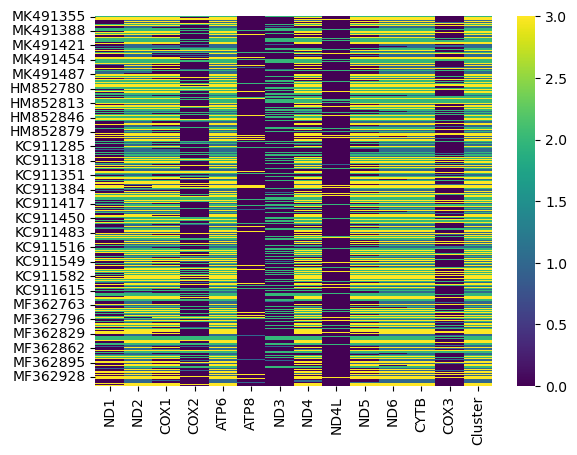

In [349]:
sns.heatmap(data_with_clusters_modify, cmap="viridis")

In [350]:
from adjustText import adjust_text

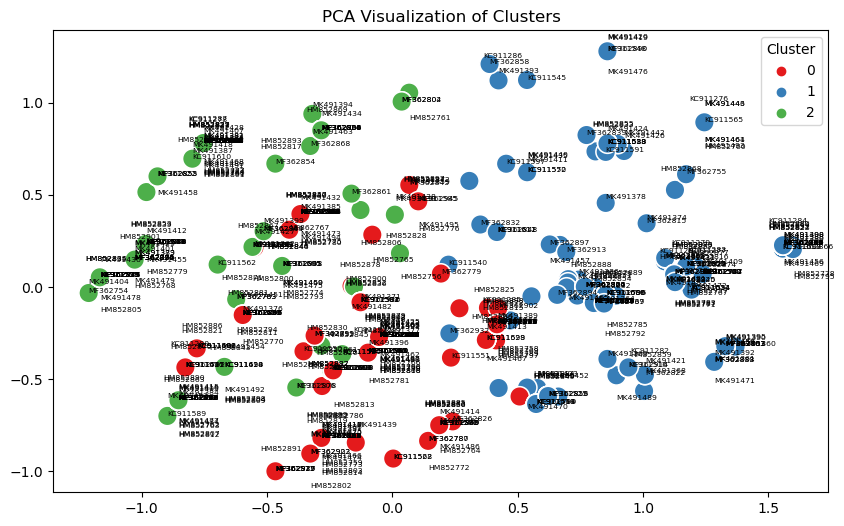

In [351]:
from matplotlib.transforms import offset_copy
from adjustText import adjust_text
# Visualize clusters using PCA
pca = PCA(2)
data_2d = pca.fit_transform(matrix_data)
#print(data_2d[:, 1])

x=data_2d[:, 0]
y=data_2d[:, 1]
types = matrix_data.index.tolist()


plt.figure(figsize=(10, 6))

sns.scatterplot(x=data_2d[:, 0], y=data_2d[:, 1], hue=cluster_labels, palette='Set1', s = 200)
plt.title('PCA Visualization of Clusters')
#plt.xlabel('Principal Component 1')
#plt.ylabel('Principal Component 2')
texts = []
offset = 0.001
offsetx = 0.0004


for i, txt in enumerate(types):
    #if (i > (len(types) / 4)):
    #if (y[i] < 200):
    #    offset_transform = offset_copy(plt.gca().transData, fig=plt.gcf(), x=0, y=i, units='points')
    #elif (i < 300):
      #  offset_transform = offset_copy(plt.gca().transData, fig=plt.gcf(), x=-10, y=i-200, units='points')
    #elif (i < 400):
     #   offset_transform = offset_copy(plt.gca().transData, fig=plt.gcf(), x=5, y=15 - i * 0.0009, units='points')
    #pastx = x[i-1]
    #pasty = y[i-1]
    #if ((x[i] - pastx > 0) and (y[i] - pasty > 0)):
     #    offset_transform = offset_copy(plt.gca().transData, fig=plt.gcf(), x=0, y=0, units='points')
    #else:
    #    if ((x[i] - pastx <= 0) and (y[i] - pasty <= 0)):
    #        offset_transform = offset_copy(plt.gca().transData, fig=plt.gcf(), x=5, y=i * 0.05, units='points')
    #    else:
    #        offset_transform = offset_copy(plt.gca().transData, fig=plt.gcf(), x=5, y=-i*0.05, units='points')
    if (i < 100):
        plt.text(x[i], y[i] + i * offset, txt, fontsize=5.5)
    elif (i < 200):
        plt.text(x[i], y[i] - i * offset, txt, fontsize=5.5)
    elif (i < 300):
        plt.text(x[i] - 0.06, y[i] + i * offsetx, txt, fontsize=5.5)
    elif (i > 500):
        plt.text(x[i], y[i], txt, fontsize=5.5)
    #elif (i < (len(types) / 3)):
     #   plt.text(x[i] - i * offsetx, y[i], txt)
    #elif (i < (len(types) / 2)):
     #   plt.text(x[i] - i * offsetx, y[i] - i * offsetx, txt)
    #else:
     #   plt.text(x[i], y[i] - i * offsetx, txt)
    #plt.scatter(x, y, marker='x', color='red')

plt.legend(title='Cluster')
plt.show()

In [352]:
matrix_data.loc[['MF362902']]

,ND1,ND2,COX1,COX2,ATP6,ATP8,ND3,ND4,ND4L,ND5,ND6,CYTB,COX3
MF362902,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [353]:
matrix_data.loc[['HM852809']]

,ND1,ND2,COX1,COX2,ATP6,ATP8,ND3,ND4,ND4L,ND5,ND6,CYTB,COX3
HM852809,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0


IndexError: index 846 is out of bounds for axis 0 with size 846

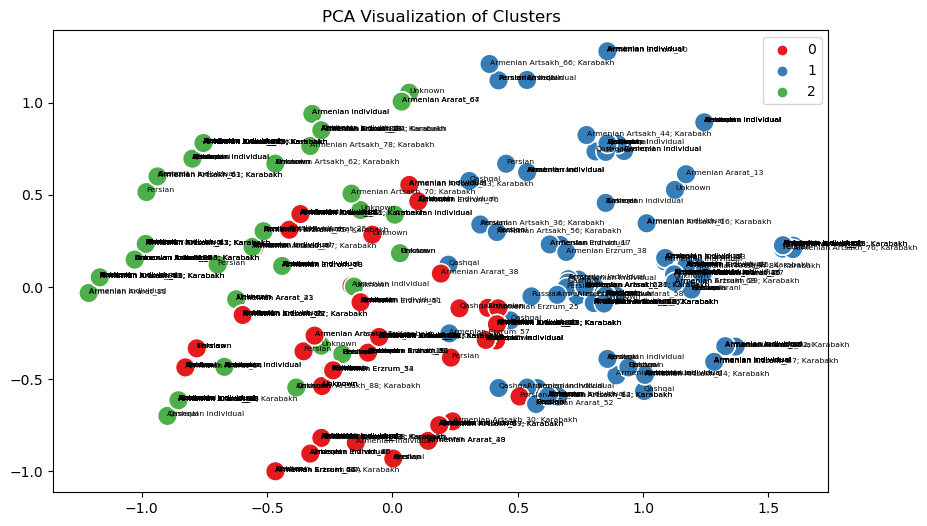

In [355]:
types_full =  meta['isolation_source']


plt.figure(figsize=(10, 6))

sns.scatterplot(x=data_2d[:, 0], y=data_2d[:, 1], hue=cluster_labels, palette='Set1', s = 200)
plt.title('PCA Visualization of Clusters')


for i, txt in enumerate(types_full):
    #if (i < 100):
    #    plt.text(x[i], y[i] + i * offset, txt, fontsize=5.5)
    #elif (i < 200):
    #    plt.text(x[i], y[i] - i * offset, txt, fontsize=5.5)
    #elif (i < 300):
    #    plt.text(x[i], y[i] + i * offsetx, txt, fontsize=5.5)
    #elif (i > 500):
    plt.text(x[i], y[i], txt, fontsize=5.5)
    #elif (i < (len(types) / 3)):
     #   plt.text(x[i] - i * offsetx, y[i], txt)
    #elif (i < (len(types) / 2)):
     #   plt.text(x[i] - i * offsetx, y[i] - i * offsetx, txt)
    #else:
     #   plt.text(x[i], y[i] - i * offsetx, txt)
    #plt.scatter(x, y, marker='x', color='red')

plt.legend(title='Cluster')
plt.show()


In [365]:


# Number of clusters
num_clusters = 4
n_init = 10
# Perform k-means clustering
kmeans = KMeans(n_clusters=num_clusters, n_init = n_init, random_state=0)
#means.fit(matrix_data)
cluster_labels = kmeans.fit_predict(matrix_data)

# Add cluster labels to the data
data_with_clusters = pd.DataFrame(matrix_data)
data_with_clusters['Cluster'] = cluster_labels


data_with_clusters

,ND1,ND2,COX1,COX2,ATP6,ATP8,ND3,ND4,ND4L,ND5,ND6,CYTB,COX3,Cluster
MK491355,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,3
MK491356,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,3
MK491357,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1
MK491358,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,3
MK491359,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MF362944,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,2
MF362945,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,3
MF362946,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2
MF362947,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1


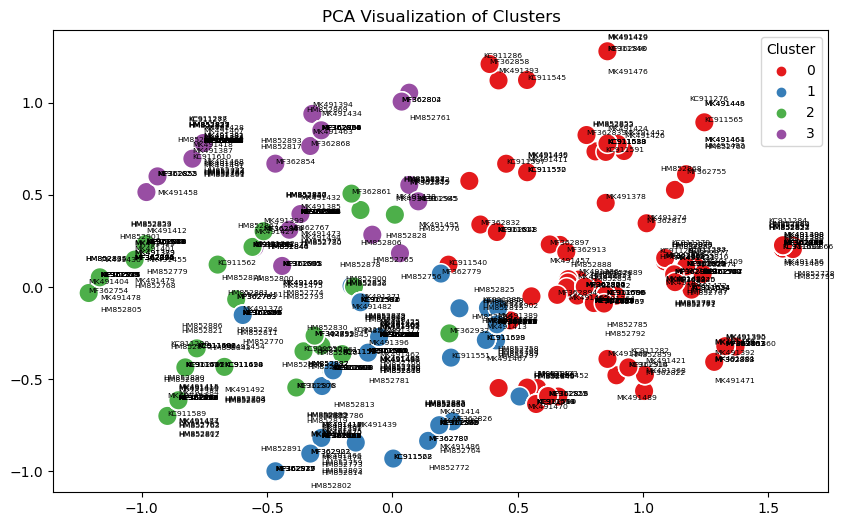

In [366]:
from matplotlib.transforms import offset_copy
from adjustText import adjust_text
# Visualize clusters using PCA
pca = PCA(2)
data_2d = pca.fit_transform(matrix_data)
#print(data_2d[:, 1])

x=data_2d[:, 0]
y=data_2d[:, 1]
types = matrix_data.index.tolist()


plt.figure(figsize=(10, 6))

sns.scatterplot(x=data_2d[:, 0], y=data_2d[:, 1], hue=cluster_labels, palette='Set1', s = 200)
plt.title('PCA Visualization of Clusters')
#plt.xlabel('Principal Component 1')
#plt.ylabel('Principal Component 2')
texts = []
offset = 0.001
offsetx = 0.0004


for i, txt in enumerate(types):
    #if (i > (len(types) / 4)):
    #if (y[i] < 200):
    #    offset_transform = offset_copy(plt.gca().transData, fig=plt.gcf(), x=0, y=i, units='points')
    #elif (i < 300):
      #  offset_transform = offset_copy(plt.gca().transData, fig=plt.gcf(), x=-10, y=i-200, units='points')
    #elif (i < 400):
     #   offset_transform = offset_copy(plt.gca().transData, fig=plt.gcf(), x=5, y=15 - i * 0.0009, units='points')
    #pastx = x[i-1]
    #pasty = y[i-1]
    #if ((x[i] - pastx > 0) and (y[i] - pasty > 0)):
     #    offset_transform = offset_copy(plt.gca().transData, fig=plt.gcf(), x=0, y=0, units='points')
    #else:
    #    if ((x[i] - pastx <= 0) and (y[i] - pasty <= 0)):
    #        offset_transform = offset_copy(plt.gca().transData, fig=plt.gcf(), x=5, y=i * 0.05, units='points')
    #    else:
    #        offset_transform = offset_copy(plt.gca().transData, fig=plt.gcf(), x=5, y=-i*0.05, units='points')
    if (i < 100):
        plt.text(x[i], y[i] + i * offset, txt, fontsize=5.5)
    elif (i < 200):
        plt.text(x[i], y[i] - i * offset, txt, fontsize=5.5)
    elif (i < 300):
        plt.text(x[i] - 0.06, y[i] + i * offsetx, txt, fontsize=5.5)
    elif (i > 500):
        plt.text(x[i], y[i], txt, fontsize=5.5)
    #elif (i < (len(types) / 3)):
     #   plt.text(x[i] - i * offsetx, y[i], txt)
    #elif (i < (len(types) / 2)):
     #   plt.text(x[i] - i * offsetx, y[i] - i * offsetx, txt)
    #else:
     #   plt.text(x[i], y[i] - i * offsetx, txt)
    #plt.scatter(x, y, marker='x', color='red')

plt.legend(title='Cluster', loc='upper right')
plt.show()

In [356]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Number of clusters
num_clusters = 10
n_init = 10
# Perform k-means clustering
kmeans = KMeans(n_clusters=num_clusters, n_init = n_init, random_state=0)
#means.fit(matrix_data)
cluster_labels = kmeans.fit_predict(matrix_data)

# Add cluster labels to the data
data_with_clusters = pd.DataFrame(matrix_data)
data_with_clusters['Cluster'] = cluster_labels


data_with_clusters

,ND1,ND2,COX1,COX2,ATP6,ATP8,ND3,ND4,ND4L,ND5,ND6,CYTB,COX3,Cluster
MK491355,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,3
MK491356,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1
MK491357,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1
MK491358,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1
MK491359,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MF362944,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0
MF362945,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,7
MF362946,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5
MF362947,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1


Another way for matrix_data visualization

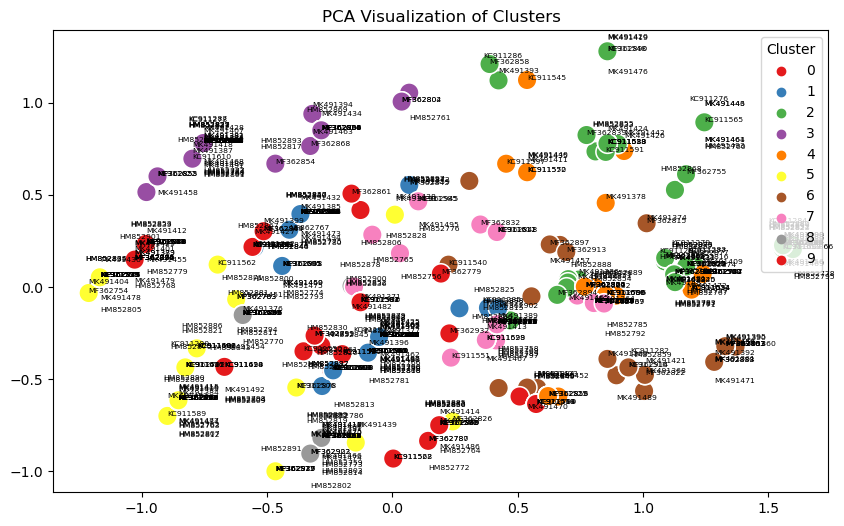

In [357]:
from matplotlib.transforms import offset_copy
from adjustText import adjust_text
# Visualize clusters using PCA
pca = PCA(2)
data_2d = pca.fit_transform(matrix_data)
#print(data_2d[:, 1])

x=data_2d[:, 0]
y=data_2d[:, 1]
types = matrix_data.index.tolist()


plt.figure(figsize=(10, 6))

sns.scatterplot(x=data_2d[:, 0], y=data_2d[:, 1], hue=cluster_labels, palette='Set1', s = 200)
plt.title('PCA Visualization of Clusters')
#plt.xlabel('Principal Component 1')
#plt.ylabel('Principal Component 2')
texts = []
offset = 0.001
offsetx = 0.0004


for i, txt in enumerate(types):
    #if (i > (len(types) / 4)):
    #if (y[i] < 200):
    #    offset_transform = offset_copy(plt.gca().transData, fig=plt.gcf(), x=0, y=i, units='points')
    #elif (i < 300):
      #  offset_transform = offset_copy(plt.gca().transData, fig=plt.gcf(), x=-10, y=i-200, units='points')
    #elif (i < 400):
     #   offset_transform = offset_copy(plt.gca().transData, fig=plt.gcf(), x=5, y=15 - i * 0.0009, units='points')
    #pastx = x[i-1]
    #pasty = y[i-1]
    #if ((x[i] - pastx > 0) and (y[i] - pasty > 0)):
     #    offset_transform = offset_copy(plt.gca().transData, fig=plt.gcf(), x=0, y=0, units='points')
    #else:
    #    if ((x[i] - pastx <= 0) and (y[i] - pasty <= 0)):
    #        offset_transform = offset_copy(plt.gca().transData, fig=plt.gcf(), x=5, y=i * 0.05, units='points')
    #    else:
    #        offset_transform = offset_copy(plt.gca().transData, fig=plt.gcf(), x=5, y=-i*0.05, units='points')
    if (i < 100):
        plt.text(x[i], y[i] + i * offset, txt, fontsize=5.5)
    elif (i < 200):
        plt.text(x[i], y[i] - i * offset, txt, fontsize=5.5)
    elif (i < 300):
        plt.text(x[i] - 0.06, y[i] + i * offsetx, txt, fontsize=5.5)
    elif (i > 500):
        plt.text(x[i], y[i], txt, fontsize=5.5)
    #elif (i < (len(types) / 3)):
     #   plt.text(x[i] - i * offsetx, y[i], txt)
    #elif (i < (len(types) / 2)):
     #   plt.text(x[i] - i * offsetx, y[i] - i * offsetx, txt)
    #else:
     #   plt.text(x[i], y[i] - i * offsetx, txt)
    #plt.scatter(x, y, marker='x', color='red')

plt.legend(title='Cluster', loc='upper right')
plt.show()

In [ ]:
data_with_clusters_ordered_10 = data_with_clusters.copy()
#data_with_clusters_ordered['population'] = "a"
lst = []
lst = meta['isolation_source']
lst = pd.DataFrame(lst)

data_with_clusters_ordered_10['isolation_source'] = meta['isolation_source'].copy()

for i in range(0, 846):
    data_with_clusters_ordered_10['isolation_source'][i] = str(meta['isolation_source'][i])

# Print the resulting DataFrame
data_with_clusters_ordered_10.to_csv("../clustered_kmeans_10.csv")


In [363]:
data_with_clusters_ordered_10 = pd.read_csv("../clustered_kmeans_10.csv")
data_with_clusters_ordered_10.reset_index()
data_with_clusters_ordered_10.sort_values(by='Cluster', inplace=True)

data_with_clusters_ordered_10.to_csv("../clustered_ordered_kmeans_10.csv")
data_with_clusters_ordered_10

,Unnamed: 0,ND1,ND2,COX1,COX2,ATP6,ATP8,ND3,ND4,ND4L,ND5,ND6,CYTB,COX3,Cluster,isolation_source
469,KC911457,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0,Persian
153,HM852768,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0,Unknown
407,KC911395,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0,Persian
487,KC911475,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0,Persian
766,MF362869,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0,Armenian Artsakh_79; Karabakh
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,HM852860,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,9,Unknown
327,KC911315,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,9,Persian
421,KC911409,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,9,Persian
258,HM852873,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,9,Unknown


ValueError: Unrecognized string ' nd1  nd2  cox1  cox2  atp6  atp8  nd3  nd4  nd4l  nd5  nd6  cytb ' to axis; try 'on' or 'off'

Error in callback <function _draw_all_if_interactive at 0x7f587acdc310> (for post_execute):


KeyboardInterrupt: 

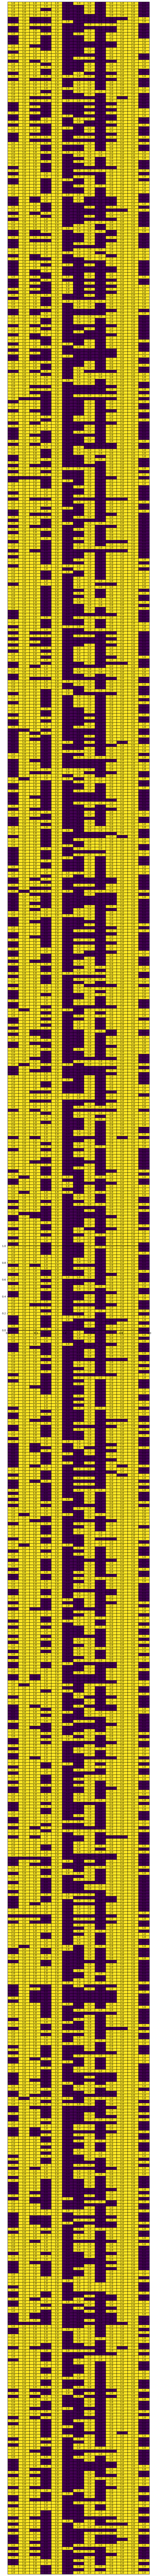

In [364]:
import matplotlib.pyplot as plt
import numpy as np

# Convert data to a NumPy array
data_array = np.array(matrix_data)

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot a table with color-coded cells
ax.table(cellText=data_array, cellColours=plt.cm.viridis(data_array), cellLoc='center', loc='center')

# Remove axes
ax.axis(" ND1  ND2  COX1  COX2  ATP6  ATP8  ND3  ND4  ND4L  ND5  ND6  CYTB ")

# Add a title
plt.title('Mutation Table')

# Show the plot
plt.show()
